Họ và tên: Phạm Đức Thể

MSSV: 19522253

Lớp: DS310.M11

Lab 03 - 28/10/2021

# Câu 1: Sử dụng mô hình LSTM để giải quyết bài toán NER cho tiếng Anh.

## Bước 1: Import Modules

In [1]:
# %matplotlib inline
import matplotlib.pyplot as plt
from io import BytesIO
import pandas as pd
import seaborn as sn
import numpy as np
import requests
np.random.seed(0)
plt.style.use("ggplot")
import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.6.0
GPU detected: []


## Bước 2: Load bộ dữ liệu NER PhoNER_COVID19

<img src="https://user-images.githubusercontent.com/2412555/112276540-741ca100-8cb3-11eb-8191-9ba6cb83c72c.png" width="800" alt="PhoNER_COVID19" />





In [2]:
%cd /content
!git clone https://github.com/VinAIResearch/PhoNER_COVID19.git

/content
fatal: destination path 'PhoNER_COVID19' already exists and is not an empty directory.


### Load tập train

In [3]:
data_train = pd.read_csv('/content/PhoNER_COVID19/data/word/train_word.conll', sep='\n\n', header=None)

Sentence_train = []
Word_train = []
Tag_train = []
flag_train = 0

for i in range(data_train.shape[0]):
  s = data_train[0][i].split()
  Sentence_train.append(flag_train)
  Word_train.append(s[0])
  Tag_train.append(s[1])
  if s[0] == '.':
    flag_train += 1

# Convert về dạng dataframe
df_train = pd.DataFrame({'Sentence': Sentence_train, 
                         'Word': Word_train,
                         'Tag': Tag_train})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [4]:
df_train

,Sentence,Word,Tag
0,0,Đồng_thời,O
1,0,",",O
2,0,bệnh_viện,O
3,0,tiếp_tục,O
4,0,thực_hiện,O
...,...,...,...
132506,4951,",",O
132507,4951,kết_quả,O
132508,4951,nghi,O
132509,4951,nhiễm,O


### Load tập dev

In [5]:
data_dev = pd.read_csv('/content/PhoNER_COVID19/data/word/dev_word.conll', sep='\n\n', header=None)

Sentence_dev = []
Word_dev = []
Tag_dev = []
flag_dev = flag_train

for i in range(data_dev.shape[0]):
  s = data_dev[0][i].split()
  Sentence_dev.append(flag_dev)
  Word_dev.append(s[0])
  Tag_dev.append(s[1])
  if s[0] == '.':
    flag_dev += 1

# Convert về dạng dataframe
df_dev = pd.DataFrame({'Sentence': Sentence_dev, 
                       'Word': Word_dev,
                       'Tag': Tag_dev})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [6]:
df_dev

,Sentence,Word,Tag
0,4952,Bác_sĩ,O
1,4952,Nguyễn_Trung_Nguyên,O
2,4952,",",O
3,4952,Giám_đốc,O
4,4952,Trung_tâm,B-ORGANIZATION
...,...,...,...
56278,6931,riêng,O
56279,6931,",",O
56280,6931,dương_tính,O
56281,6931,nCoV,O


### Load tập test

In [7]:
data_test = pd.read_csv('/content/PhoNER_COVID19/data/word/test_word.conll', sep='\n\n', header=None)

Sentence_test = []
Word_test = []
Tag_test = []
flag_test = flag_dev

for i in range(data_test.shape[0]):
  s = data_test[0][i].split()
  if len(s) < 2: # Vì lỗi ở dòng 14937 có word mà không có Tag nên ta sẽ bỏ qua từ này từ 'bệnh'
    continue
  Sentence_test.append(flag_test)
  Word_test.append(s[0])
  Tag_test.append(s[1])
  if s[0] == '.':
    flag_test += 1

# Convert về dạng dataframe
df_test = pd.DataFrame({'Sentence': Sentence_test, 
                        'Word': Word_test,
                        'Tag': Tag_test})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [8]:
df_test

,Sentence,Word,Tag
0,6932,Từ,O
1,6932,24,B-DATE
2,6932,-,I-DATE
3,6932,7,I-DATE
4,6932,đến,O
...,...,...,...
85672,9888,nhiệt_đới,I-LOCATION
85673,9888,trung_ương,I-LOCATION
85674,9888,cơ_sở,I-LOCATION
85675,9888,Đông_Anh,I-LOCATION


Lỗi ở dòng 14937 có word mà không có Tag

Merge 3 tập dữ liệu lại với nhau để thực hiện bước 4

In [9]:
data = pd.concat([df_train, df_dev, df_test], ignore_index=True)

In [10]:
data

,Sentence,Word,Tag
0,0,Đồng_thời,O
1,0,",",O
2,0,bệnh_viện,O
3,0,tiếp_tục,O
4,0,thực_hiện,O
...,...,...,...
274466,9888,nhiệt_đới,I-LOCATION
274467,9888,trung_ương,I-LOCATION
274468,9888,cơ_sở,I-LOCATION
274469,9888,Đông_Anh,I-LOCATION


## Visualizing the Sentenceentence
Thông kê bộ dữ liệu:
- Số lượng từ duy nhất trong kho ngữ liệu. (Tập từ vựng, số chiều)
- Số lượng thẻ duy nhất trong tập dữ liệu. (Tập nhãn)


Bằng cách sử dụng hàm **“nunique”.**

In [11]:
print("Unique words in corpus:", data['Word'].nunique())
print("Unique tags in corpus:", data['Tag'].nunique())

Unique words in corpus: 8101
Unique tags in corpus: 21


Tạo một danh sách và sử dụng phương thức set() để lấy các giá trị trong cột “word” và loại bỏ giá trị trùng.\
Thêm phần đệm có tên “Endpad”.


In [12]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [13]:
print(words)
print(num_words)

['937', 'Hoà_Nhơn', 'từ', 'Ba_Đồn', 'Quảng_Trị', 'Cha_mẹ', 'Trạm', 'giải_trí', 'Hướng_Tân', 'bàn_tán', 'Từ', 'công_ty', 'đồ_dùng', 'chứ', 'giỏi', 'tiềm_tàng', 'cháu', '785', '749', 'chế_phẩm', '13/4', 'SK', '55', '8059', 'run_rẩy', 'Phong_An', 'mai_táng', 'bán', '10h20', 'Nguyễn_Đức_Cường', 'Quy_trình', 'Ngoài_ra', 'Nhà_ăn', '8/8', 'AirJapan', '668', '3D', 'dân_phòng', 'lâu_dài', '864', 'Trùng_Khánh', '81/110', '174', 'VN54', '477', 'giáo_dục', 'VĨNH_CHÂU', 'lạnh', 'Khoa_Khám', 'kết_nối', '732,733', 'khan', 'Tây_Bắc_Nghệ_An', '1/2', 'đất_nước', 'số_lượng', '625', '135', 'đôi_khi', 'Bắc_Ninh', 'dới', 'môi_trường', 'H.C.G', 'vậy', '8/6', 'nêu', 'xâm_nhập', 'Mắt', 'Phổ_Yên', '114', 'Bệnh_sử', '\u200b', '830', 'vắng_lặng', '2.000', '31/5', '136', 'MI', '108', 'xương', '1000', 'cầu_thang', 'Quân_đoàn', 'dự_trù', '28/6', 'Hoà_Khê', 'quyết_liệt', 'Thi_thể', 'trước', 'Võ_Hùng', 'túi_mật', 'phố_phường', 'Thanh_Quang', '364', 'thị', '254', 'an_toàn', 'Lân', '418', 'L.M.H.', 'dã', 'AK575', 'Ho

In [14]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

In [15]:
print(tags)

['I-ORGANIZATION', 'I-PATIENT_ID', 'B-DATE', 'B-AGE', 'I-NAME', 'B-ORGANIZATION', 'I-LOCATION', 'O-ORGANIZATION', 'I-AGE', 'B-PATIENT_ID', 'B-TRANSPORTATION', 'O', 'I-JOB', 'I-DATE', 'I-TRANSPORTATION', 'I-SYMPTOM_AND_DISEASE', 'B-SYMPTOM_AND_DISEASE', 'B-JOB', 'B-LOCATION', 'B-NAME', 'B-GENDER']


In [16]:
print('Tổng số từ duy nhất:', num_words)
print('Số lượng nhãn thực thể:', num_tags)

Tổng số từ duy nhất: 8102
Số lượng nhãn thực thể: 21


## Bước 3: Lấy các câu và các thẻ tương ứng

In [17]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                     s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence").apply(agg_func)
        self.sentences = [s for s in self.grouped]

#các bạn có thể viết theo cách khác

In [18]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [19]:
sentences[1]

[('"', 'O'),
 ('Số', 'O'),
 ('bệnh_viện', 'O'),
 ('có_thể', 'O'),
 ('tiếp_nhận', 'O'),
 ('bệnh_nhân', 'O'),
 ('bị', 'O'),
 ('sốt', 'B-SYMPTOM_AND_DISEASE'),
 ('cao', 'I-SYMPTOM_AND_DISEASE'),
 ('và', 'O'),
 ('khó', 'B-SYMPTOM_AND_DISEASE'),
 ('thở', 'I-SYMPTOM_AND_DISEASE'),
 ('đang', 'O'),
 ('giảm', 'O'),
 ('dần', 'O'),
 ('"', 'O'),
 (',', 'O'),
 ('thông_cáo', 'O'),
 ('có', 'O'),
 ('đoạn', 'O'),
 (',', 'O'),
 ('cảnh_báo', 'O'),
 ('những', 'O'),
 ('bệnh_nhân', 'O'),
 ('này', 'O'),
 ('thay', 'O'),
 ('vào', 'O'),
 ('đó', 'O'),
 ('được', 'O'),
 ('chuyển', 'O'),
 ('tới', 'O'),
 ('các', 'O'),
 ('phòng_khám', 'O'),
 ('khẩn_cấp', 'O'),
 (',', 'O'),
 ('khiến', 'O'),
 ('những', 'O'),
 ('bệnh_nhân', 'O'),
 ('mắc', 'O'),
 ('bệnh', 'O'),
 ('hiểm_nghèo', 'O'),
 ('khác', 'O'),
 ('không', 'O'),
 ('có', 'O'),
 ('cơ_hội', 'O'),
 ('được', 'O'),
 ('điều_trị', 'O'),
 ('.', 'O')]

## Bước 4: Ánh xạ giữa các câu và chỉ mục
Chúng ta có thể thấy rằng mỗi từ được gán cho một thẻ duy nhất. Chúng tôi có thể truy xuất những từ này bằng cách sử dụng các chỉ số của chúng và tra cứu chúng trong từ điển và trả về các khóa tương ứng.


In [20]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [21]:
word2idx

{'937': 0,
 'Hoà_Nhơn': 1,
 'từ': 2,
 'Ba_Đồn': 3,
 'Quảng_Trị': 4,
 'Cha_mẹ': 5,
 'Trạm': 6,
 'giải_trí': 7,
 'Hướng_Tân': 8,
 'bàn_tán': 9,
 'Từ': 10,
 'công_ty': 11,
 'đồ_dùng': 12,
 'chứ': 13,
 'giỏi': 14,
 'tiềm_tàng': 15,
 'cháu': 16,
 '785': 17,
 '749': 18,
 'chế_phẩm': 19,
 '13/4': 20,
 'SK': 21,
 '55': 22,
 '8059': 23,
 'run_rẩy': 24,
 'Phong_An': 25,
 'mai_táng': 26,
 'bán': 27,
 '10h20': 28,
 'Nguyễn_Đức_Cường': 29,
 'Quy_trình': 30,
 'Ngoài_ra': 31,
 'Nhà_ăn': 32,
 '8/8': 33,
 'AirJapan': 34,
 '668': 35,
 '3D': 36,
 'dân_phòng': 37,
 'lâu_dài': 38,
 '864': 39,
 'Trùng_Khánh': 40,
 '81/110': 41,
 '174': 42,
 'VN54': 43,
 '477': 44,
 'giáo_dục': 45,
 'VĨNH_CHÂU': 46,
 'lạnh': 47,
 'Khoa_Khám': 48,
 'kết_nối': 49,
 '732,733': 50,
 'khan': 51,
 'Tây_Bắc_Nghệ_An': 52,
 '1/2': 53,
 'đất_nước': 54,
 'số_lượng': 55,
 '625': 56,
 '135': 57,
 'đôi_khi': 58,
 'Bắc_Ninh': 59,
 'dới': 60,
 'môi_trường': 61,
 'H.C.G': 62,
 'vậy': 63,
 '8/6': 64,
 'nêu': 65,
 'xâm_nhập': 66,
 'Mắt': 67,


In [22]:
tag2idx

{'B-AGE': 3,
 'B-DATE': 2,
 'B-GENDER': 20,
 'B-JOB': 17,
 'B-LOCATION': 18,
 'B-NAME': 19,
 'B-ORGANIZATION': 5,
 'B-PATIENT_ID': 9,
 'B-SYMPTOM_AND_DISEASE': 16,
 'B-TRANSPORTATION': 10,
 'I-AGE': 8,
 'I-DATE': 13,
 'I-JOB': 12,
 'I-LOCATION': 6,
 'I-NAME': 4,
 'I-ORGANIZATION': 0,
 'I-PATIENT_ID': 1,
 'I-SYMPTOM_AND_DISEASE': 15,
 'I-TRANSPORTATION': 14,
 'O': 11,
 'O-ORGANIZATION': 7}

## Bước 5: Padding  đầu vào và cắt dữ liệu thành tập Train/Test
Trong trục X, có thể thấy độ dài an toàn của câu là khoảng 80.

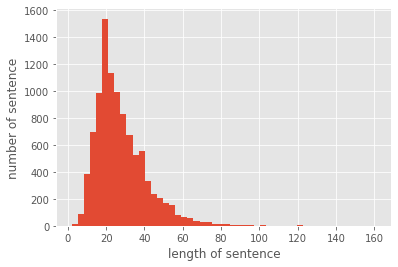

In [23]:
plt.hist([len(s) for s in sentences], bins=50)
plt.xlabel("length of sentence")
plt.ylabel('number of sentence')
plt.show()

- Sử dụng hàm pad_sequence() cho padding
- X sẽ là một đại diện bằng số cho các từ. (sử dụng word2idx)
- ‘Post’ chỉ là một giá trị của đối số đệm ở cuối câu.
- X,y là vector

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_len = 80
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [25]:
print(X[0])
print(y[0])

[3581 7376 5783 3128 5961  891 4342 1227 3799 1583 3285 1657 6209 3085
 5895 4183 4401  666 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101]
[11 11 11 11 11 11 11 11 11 11 11 11 11 11 11  5  0 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11]


Chia lại tập train, dev, test

In [26]:
# tập train
X_train = X[0:flag_train]
y_train = y[0:flag_train]
# tập dev
X_dev = X[flag_train:flag_dev]
y_dev = y[flag_train:flag_dev]
# tập test
X_test = X[flag_dev:]
y_test = y[flag_dev:]

## Bước 6: Xây dựng Mô hình LSTM hai chiều (bi-LSTM)


In [27]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

Bản tóm tắt cho thấy rằng chúng ta có hơn 797 nghìn tham số cần được huấn luyện.

In [28]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=80, input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation="softmax"))(model)
model = Model(input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 80, 80)            648160    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 80, 80)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 80, 200)           144800    
_________________________________________________________________
time_distributed (TimeDistri (None, 80, 21)            4221      
Total params: 797,181
Trainable params: 797,181
Non-trainable params: 0
_________________________________________________________________


- Sử dụng trình tối ưu hoá "adam"
- sparce_categorical_crossentropy làm hàm mất mát
- Ma trận mà chúng ta sẽ quan tâm là ma trận độ chính xác.

In [29]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
# Dừng sớm để tránh overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

## Bước 7: Huấn luyện Model

- Để bắt đầu huấn luyện là gọi model.fit ()
- Có thể tăng kích thước batch_size nếu bạn có GPU có kích thước bộ nhớ lớn.



In [30]:
# Các bạn nhớ là phải lưu mô hình khi train (có nhắc lại yêu cầu ở cuối) 
import time
start_time = time.time()

history = model.fit(X_train, y_train, validation_data=(X_dev, y_dev),
                    batch_size= 32, epochs=20, callbacks=[callback])

print("[{}] Completed!".format(time.time() - start_time))

Epoch 1/20
155/155 [==============================] - 55s 327ms/step - loss: 0.5072 - accuracy: 0.9235 - val_loss: 0.3352 - val_accuracy: 0.9112
Epoch 2/20
155/155 [==============================] - 50s 322ms/step - loss: 0.2020 - accuracy: 0.9433 - val_loss: 0.2144 - val_accuracy: 0.9421
Epoch 3/20
155/155 [==============================] - 50s 323ms/step - loss: 0.1190 - accuracy: 0.9672 - val_loss: 0.1326 - val_accuracy: 0.9677
Epoch 4/20
155/155 [==============================] - 50s 323ms/step - loss: 0.0641 - accuracy: 0.9843 - val_loss: 0.0928 - val_accuracy: 0.9773
Epoch 5/20
155/155 [==============================] - 50s 323ms/step - loss: 0.0406 - accuracy: 0.9898 - val_loss: 0.0787 - val_accuracy: 0.9798
Epoch 6/20
155/155 [==============================] - 50s 323ms/step - loss: 0.0302 - accuracy: 0.9920 - val_loss: 0.0742 - val_accuracy: 0.9812
Epoch 7/20
155/155 [==============================] - 50s 322ms/step - loss: 0.0240 - accuracy: 0.9935 - val_loss: 0.0696 - val_ac

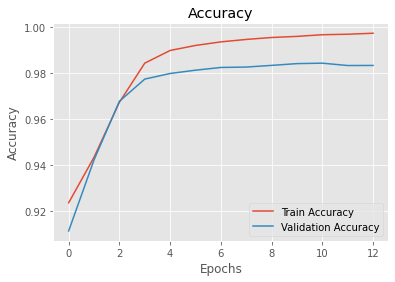

In [31]:
plt.plot(history.history['accuracy'], label = 'Train Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

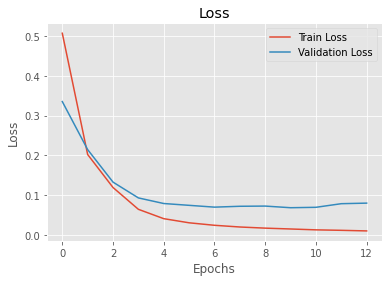

In [32]:
plt.plot(history.history['loss'], label = 'Train Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Bước 8: Đánh giá mô hình NER



In [33]:
model.evaluate(X_test, y_test)

93/93 [==============================] - 4s 45ms/step - loss: 0.0796 - accuracy: 0.9815


[0.07964631915092468, 0.981488823890686]

- Dự đoán

In [34]:
# i = np.random.randint(0, X_test.shape[0]) #659
print(X_test[0])
i = 2
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:25}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" *30)
for w, true, pred in zip(X_test[i], y_true, p[0]):
    print("{:25}{:10}\t{}".format(words[w], tags[true], tags[pred]))

[  10 4834 3285 4241 2383 7106 3285 4241 7376 6979 2565 5728 7510 1656
 4558 2141 3304 6810 1859 3479 3082 2422 5214 7539 1009 2141 5187  472
 1859 7376 2217 7121 4535 6096 6510  999 3972 7376 1233 4864 7376 7539
 6843 2435 5728   27 7401 5214 2614  666 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101
 8101 8101 8101 8101 8101 8101 8101 8101 8101 8101]
Word                     True      	 Pred

------------------------------
Theo                     O         	O
đó                       O         	O
,                        O         	O
Sở                       B-ORGANIZATION	B-ORGANIZATION
Y_tế                     I-ORGANIZATION	I-ORGANIZATION
Bình_Thuận               I-ORGANIZATION	I-ORGANIZATION
cho                      O         	O
biết                     O         	O
sau                      O         	O
khi                      O         	O
xác_định                 O         	O
bệnh_nhân                O         	O
số          

## Bước 9: Yêu cầu

### Đánh giá mô hình theo độ đo F1-score

In [35]:
!pip install seqeval

predict tập test

In [36]:
y_true = []
y_pred = []
for i in range(y_test.shape[0]):
  y_true.append(y_test[i])
  p = model.predict(np.array([X_test[i]]))
  p = np.argmax(p, axis=-1)
  y_pred.extend(p)

In [37]:
Y_true = []
Y_pred = []

for i, j in zip(range(len(y_true)), range(len(y_pred))):
  true = []
  pred = []
  for k in range(len(y_true[i])):
    true.append(tags[y_true[i][k]])
    pred.append(tags[y_pred[j][k]])
  Y_true.append(true)
  Y_pred.append(pred)

In [38]:
from seqeval.metrics import f1_score

print('F1-score micro test set: {}%'.format(round(f1_score(Y_true, Y_pred, average='micro')*100,2)))
print('F1-score macro test set: {}%'.format(round(f1_score(Y_true, Y_pred, average='macro')*100,2)))

F1-score micro test set: 82.67%
F1-score macro test set: 75.54%


### F1-score và Accuracy cho từng nhãn thực thể. 

#### F1-score

In [39]:
from collections import Iterable
def flatten(lis):
     for item in lis:
         if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                 yield x
         else:        
             yield item

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  """Entry point for launching an IPython kernel.


In [40]:
YT = list(flatten(Y_true))
YP = list(flatten(Y_pred))

In [41]:
from sklearn.metrics import classification_report as sklearn_cs

print(sklearn_cs(YT, YP))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                B-AGE       0.89      0.93      0.91       568
               B-DATE       0.97      0.96      0.97      1640
             B-GENDER       0.90      0.90      0.90       447
                B-JOB       0.61      0.37      0.46       172
           B-LOCATION       0.93      0.87      0.90      4425
               B-NAME       0.83      0.53      0.65       317
       B-ORGANIZATION       0.84      0.82      0.83       769
         B-PATIENT_ID       0.92      0.86      0.89      1978
B-SYMPTOM_AND_DISEASE       0.90      0.81      0.85      1134
     B-TRANSPORTATION       0.93      0.59      0.72       193
                I-AGE       0.00      0.00      0.00         6
               I-DATE       0.95      0.99      0.97      1726
                I-JOB       0.57      0.04      0.07       114
           I-LOCATION       0.94      0.81      0.87      4892
               I-NAME       0.00      0.00      0.00  

In [42]:
from seqeval.metrics import classification_report as seqeval_cs

print(seqeval_cs(Y_true, Y_pred, digits =4))

                     precision    recall  f1-score   support

                AGE     0.8878    0.9190    0.9031       568
               DATE     0.9357    0.9397    0.9377      1642
             GENDER     0.8958    0.9038    0.8998       447
                JOB     0.4486    0.2791    0.3441       172
           LOCATION     0.8297    0.8122    0.8209      4426
               NAME     0.8137    0.5237    0.6372       317
       ORGANIZATION     0.6589    0.7299    0.6925       770
         PATIENT_ID     0.9126    0.8549    0.8828      1978
SYMPTOM_AND_DISEASE     0.7541    0.7302    0.7419      1134
     TRANSPORTATION     0.8819    0.5714    0.6935       196

          micro avg     0.8409    0.8130    0.8267     11650
          macro avg     0.8019    0.7264    0.7554     11650
       weighted avg     0.8402    0.8130    0.8245     11650



#### Accuracy

In [43]:
from seqeval.metrics import accuracy_score

accuracy = round(accuracy_score(Y_true, Y_pred)*100,2)
print('Accuracy test = {}%'.format(accuracy))

Accuracy test = 98.15%


Confusion matrix với các nhãn tương ứng như sau

B-AGE - 0     
B-DATE - 1        
B-GENDER - 2        
B-JOB - 3        
B-LOCATION - 4        
B-NAME - 5        
B-ORGANIZATION - 6        
B-PATIENT_ID - 7        
B-SYMPTOM_AND_DISEASE - 8        
B-TRANSPORTATION - 9        
I-AGE - 10        
I-DATE - 11       
I-JOB - 12        
I-LOCATION - 12        
I-NAME - 14        
I-ORGANIZATION - 15        
I-PATIENT_ID - 16        
I-SYMPTOM_AND_DISEASE - 17        
I-TRANSPORTATION - 18        
O - 19        

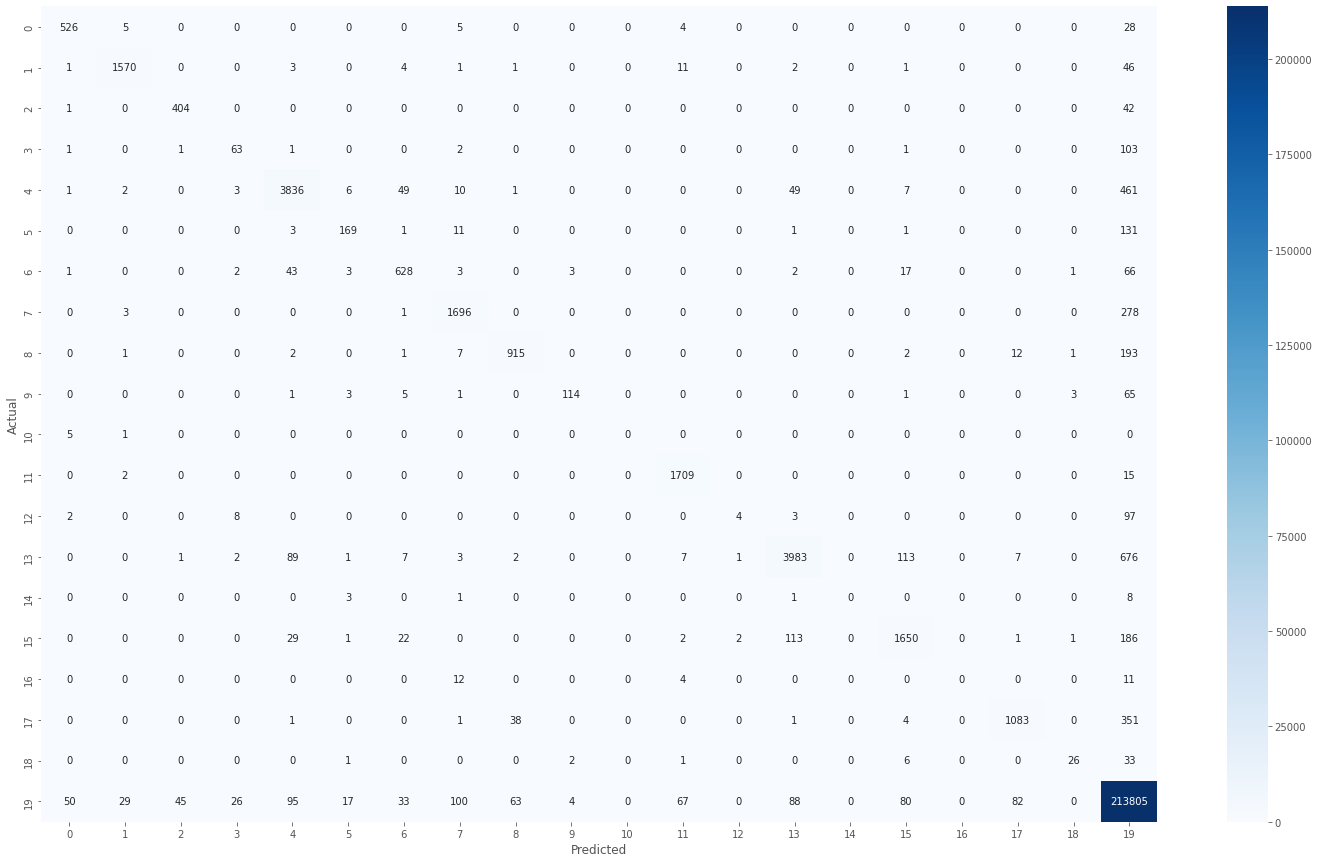

In [44]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(YT, YP) 
plt.figure(figsize=(25,15))
sn.heatmap(cm, annot=True, cmap = 'Blues', fmt='g', cbar=True, annot_kws={"size": 10})
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [45]:
labels=['B-AGE', 'B-DATE', 'B-GENDER', 'B-JOB', 'B-LOCATION', 'B-NAME', 'B-ORGANIZATION', 'B-PATIENT_ID', 'B-SYMPTOM_AND_DISEASE', 'B-TRANSPORTATION', 
        'I-AGE', 'I-DATE', 'I-JOB', 'I-LOCATION', 'I-NAME', 'I-ORGANIZATION', 'I-PATIENT_ID', 'I-SYMPTOM_AND_DISEASE', 'I-TRANSPORTATION', 'O' ]
# Accuracy của từng nhãn thực thể
acc_class = cm.diagonal()/cm.sum(axis=1) 
df_acc_class = pd.DataFrame({'Label': labels,
                             'Accuracy': acc_class})
df_acc_class

,Label,Accuracy
0,B-AGE,0.926056
1,B-DATE,0.957317
2,B-GENDER,0.903803
3,B-JOB,0.366279
4,B-LOCATION,0.866893
5,B-NAME,0.533123
6,B-ORGANIZATION,0.816645
7,B-PATIENT_ID,0.857432
8,B-SYMPTOM_AND_DISEASE,0.806878
9,B-TRANSPORTATION,0.590674


### Lưu lại mô hình và bộ trọng số đã train. 

In [46]:
# Chuyển đến thư mục cần lưu model
%cd '/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS310.M11 - XỬ LÝ NGÔN NGỮ TỰ NHIÊN CHO KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB04 28 10 2021'

/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS310.M11 - XỬ LÝ NGÔN NGỮ TỰ NHIÊN CHO KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB04 28 10 2021


In [47]:
pwd

'/content/drive/MyDrive/TÀI LIỆU HỌC TẬP ĐẠI HỌC 2019-2023/NĂM 3 2021-2022/HỌC KỲ 1 2021 - 2022/DS310.M11 - XỬ LÝ NGÔN NGỮ TỰ NHIÊN CHO KHOA HỌC DỮ LIỆU/THỰC HÀNH/LAB/LAB04 28 10 2021'

In [48]:
ls

NER_Câu1_LSTM_19522253.ipynb       NER_Câu2_LSTM_19522253_model.h5
NER_Câu1_LSTM_19522253_model.h5    NER_Câu2_LSTM_19522253_weights.h5
NER_Câu1_LSTM_19522253_weights.h5  NER_Câu2_RNN_19522253.ipynb
NER_Câu1_RNN_19522253.ipynb        NER_Câu2_RNN_19522253_model.h5
NER_Câu1_RNN_19522253_model.h5     NER_Câu2_RNN_19522253_weights.h5
NER_Câu1_RNN_19522253_weights.h5   ner_dataset.csv
NER_Câu2_LSTM_19522253.ipynb       NER-LSTM.ipynb


In [49]:
# Lưu bộ trọng số đã train
model.save_weights('NER_Câu2_LSTM_19522253_weights.h5')

In [50]:
# Lưu mô hình đã train
model.save('NER_Câu2_LSTM_19522253_model.h5')